[INFO    ] csr.py: module PYFFTW is not installed. Install it to speed up calculation.
[INFO    ] csr.py: module NUMEXPR is not installed. Install it to speed up calculation


initializing ocelot...
import: module PYFFTW is not installed. Install it to speed up calculation
import: module NUMEXPR is not installed. Install it to speed up calculation


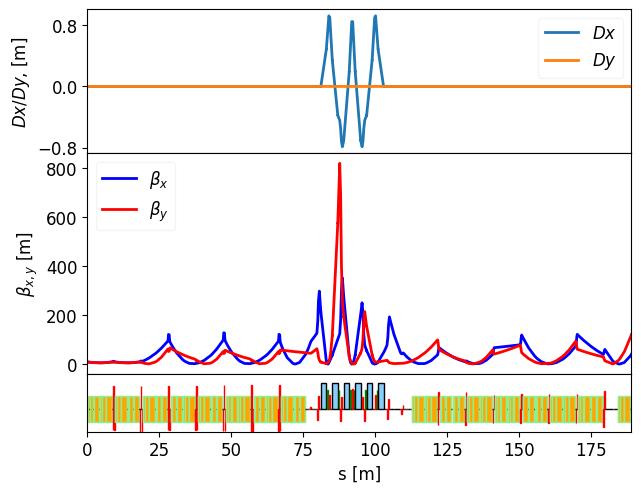

In [1]:
import sys
sys.path.append('/Users/iagapov/workspace/ocelot.2024/ocelot')
#sys.path.append('/Users/iagapov/workspace/ocelot')
from ocelot import *
from ocelot.cpbd.elements import *

from ocelot.gui.accelerator import *

from utils import trunc_s, show_parameter_evolution

#from linac_btp_p1 import *
#from linac_btp import *
from test_optics import *

# 1250 - after linac
# 1350 - after second chicane
# 1600 - before the second arc
lat = MagneticLattice(lattice_list[0:1100])  
#lat = MagneticLattice(lattice_list)

#AX =2.7906447390331426 BX =6.776927886467602    PSIX =56.49535868579681  AY =-5.526446108975507
#           BY =10.553017034834932   PSIY =44.56549637932061  EX =.027326899999999998  EPX =-.005690000000000001     EY =-.0159411
#           EPY =-.0084628 DX =-1.6293750997286722e-15   DPX =1.163621669096704e-15    DZ =-1.3638179127695162e-15   
#           DP =.00055     EMITX =3.09988e-08  EMITY =3.0999e-11

energy = 0.5  # GeV
tw0 = Twiss()
tw0.alpha_x = 0.83305
tw0.beta_x = 8.80

tw0.alpha_y = 0.81046
tw0.beta_y = 8.82335
tw0.E = energy
tw0.emit_xn = 10.e-6
tw0.emit_yn = 10.e-6
tw0.emit_x = 10.e-6 / energy * 0.511e-3
tw0.emit_y = 10.e-6 / energy * 0.511e-3

tws = twiss(lat,tw0)

plot_opt_func(lat, tws,legend=False, grid=False, top_plot=['Dx','Dy'])

In [ ]:
# tracking
nparticles=100000
p_array=ParticleArray(n=nparticles)

sigma_tau = 9.9e-4 # m
sigma_p = 5.e-4

p_array.E = energy # GeV
p_array.rparticles[0] = np.zeros(nparticles)
p_array.rparticles[1] = np.zeros(nparticles)
p_array.rparticles[2] = np.zeros(nparticles)
p_array.rparticles[3] = np.zeros(nparticles)
p_array.rparticles[4] = np.random.randn(nparticles) * sigma_tau
p_array.rparticles[5] = np.random.randn(nparticles) * sigma_p

charge = 4.0e-9 # 4 nC

p_array.q_array = np.ones(nparticles) * charge / nparticles

for i in range(nparticles):
    p_array.rparticles[0][i], p_array.rparticles[1][i] = gauss_from_twiss(tw0.emit_x,tw0.beta_x, tw0.alpha_x )
    p_array.rparticles[2][i], p_array.rparticles[3][i] = gauss_from_twiss(tw0.emit_y,tw0.beta_y, tw0.alpha_y )


In [ ]:
show_e_beam(p_array)

In [ ]:
import time
navi = Navigator(lat)
navi.unit_step = 0.1 # m, only with CSR

#csr = CSR(n_bin=500, m_bin=5, sigma_min=.2e-6)

csr = CSR(n_bin=500, m_bin=5, sigma_min=.2e-6)
navi.add_physics_proc(csr, csrm1_start, csrm1_end)

#navi.add_physics_proc(csr, cstart, cend)

p_array_t = deepcopy(p_array)
start = time.time()
tws_track, p_array_t = track(lat, p_array_t, navi)
print("\n time exec:", time.time() - start, "sec")


In [ ]:
show_parameter_evolution(tws_track)


In [ ]:
# make two celss: first for first part w/0 CSR
# second for second part with CSR (create/check full optics first)

show_e_beam(p_array_t)
